# Code for figures 1 and 2

This code was used for the analysis presented in  
"Do higher-order interactions promote synchronization?"  
by Yuanzhao Zhang, Maxime Lucas, and Federico Battiston

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sb
from labellines import labelLines 

import utils as hu # separate script with our functions

sb.set_context("paper")
sb.set_theme(style="ticks")

## Fig. 1: Lyapunov exponents for random hypergraph and simplicial complexes

First, we generate the random hyperedges.

In [4]:
N = 100 # number of nodes
ps = [0.1, 0.1] # ps[i] is the wiring probability of any i+2 nodes (ps[0] is for edges, e.g.)
alpha = 0.5 # ratio between coupling strength of 1st and 2nd order interaction (must be in [0,1])
# rescale = True # whether to reascel 

n_repetitions = 50 # number of realisations of random hypergraph

# generate hyperedges of random hypergraph 
hyperedges_random_HG_arr = [hu.random_hypergraph(N, ps) for i in range(n_repetitions)]

In [8]:
# generate hyperedges of random simplicial complex
hyperedges_random_MSC_arr = [hu.random_maximal_simplicial_complex_d2(N, p=0.5) for i in range(n_repetitions)]

Then, we compute the Laplacians and the associated Lyapunov exponents.

In [9]:
alphas = np.arange(0, 1.01, 0.1)
n_alpha = len(alphas)

lyaps_alpha_HG_arr = np.zeros((n_alpha, N, n_repetitions))

# compute Lyapunov exponents for all alpha values
for j, hyperedges_random_HG in enumerate(hyperedges_random_HG_arr): 
    
    for i, alpha in enumerate(alphas) : 
        lyap_1, lyap_2, lyap_12 = hu.compute_eigenvalues_resource_constrained(hyperedges_random_HG, N, alpha=alpha)
        lyap_s_HG = np.sort(lyap_12)[::-1]
        lyaps_alpha_HG_arr[i,:,j] = lyap_s_HG 
        
lyaps_alpha_MSC_arr = np.zeros((n_alpha, N, n_repetitions))

# compute Lyapunov exponents for all alpha values
for j, hyperedges_random_MSC in enumerate(hyperedges_random_MSC_arr): 
    
    for i, alpha in enumerate(alphas) : 
        lyap_1, lyap_2, lyap_12 = hu.compute_eigenvalues_resource_constrained(hyperedges_random_MSC, N, alpha=alpha)
        lyap_s_MSC = np.sort(lyap_12)[::-1]
        lyaps_alpha_MSC_arr[i,:,j] = lyap_s_MSC            

In [10]:
# average over the random realisations
means_HG = np.mean(lyaps_alpha_HG_arr[:, 1,:], axis=1)
std_HG = np.std(lyaps_alpha_HG_arr[:, 1,:], axis=1)

means_MSC = np.mean(lyaps_alpha_MSC_arr[:, 1,:], axis=1)
std_MSC = np.std(lyaps_alpha_MSC_arr[:, 1,:], axis=1)

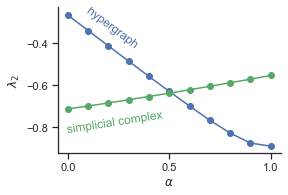

In [12]:
fig, ax = plt.subplots(figsize=(4, 2.7))

# sb.set_palette('tab10')

ax.errorbar(alphas, means_HG, yerr=std_HG/np.sqrt(n_repetitions), fmt='-o', color='C0', 
            ecolor='gray', elinewidth=3, capsize=0, label='hypergraph')

ax.errorbar(alphas, means_MSC, yerr=std_MSC/np.sqrt(n_repetitions), fmt='-o', color='C2',
            ecolor='gray', elinewidth=3, capsize=0, label='simplicial complex')


ax.set_ylabel(r"$\lambda_2$")
ax.set_xlabel(r"$\alpha$")

ax.set_xticks([0, 0.5, 1])

# pretty curves labels instead of legend
xvals = [0.22, 0.23]
labelLines(plt.gca().get_lines(), align=True, xvals=xvals, yoffsets=[0.1, -0.1])

sb.despine()
# ax.legend()

fig_name = f"lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

# plt.savefig(f"{fig_name}.pdf", dpi=250, bbox_inches="tight")

plt.show()

## Fig. 2: Pairwise and non-pairwise interactions synergize to optimize synchronization

First, we generate the random hypergraphs

In [19]:
N = 100 # number of nodes

p_0s = [0.2, 0.4, 0.6, 0.8]
p_1 = 0.05
alphas = np.arange(0, 1.01, 0.05)

lyaps_arr = np.zeros((len(p_0s), len(alphas), N))

for j, p_0 in enumerate(p_0s) : 
    
    ps = [p_0, p_1] # ps[i] is the wiring probability of any i+2 nodes (ps[0] is for edges, e.g.)

    # generate hyperedges 
    hyperedges_random = hu.random_hypergraph(N, ps)

    _, _, lyaps_12 = hu.compute_eigenvalues_resource_constrained_alphas(hyperedges_random, N, alphas)
    lyaps_12_s = np.sort(lyaps_12)[:, ::-1]
    lyaps_arr[j] = lyaps_12_s

Then, we plot the results

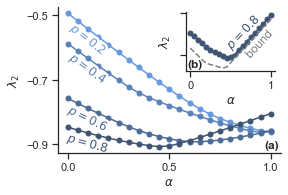

In [20]:
fig, ax = plt.subplots(figsize=(4, 2.7))

palette = sb.dark_palette("#69d", reverse=True)
sb.set_palette(palette)

for i, p_0 in enumerate(p_0s) : 
    
    ax.plot(alphas, lyaps_arr[i,:,1], 'o-', label=f"$p={p_0:.1f}$", ms=5)

def bound_multi(alpha, hyperedges, N) : 
    """Returns the lower bound N/(N-1) k_min"""
    L1, L2, L12, K1, K2 = hu.compute_laplacians_resource_constrained(hyperedges, N, alpha=alpha, return_k=True)
    K12 = np.diag(L12)
    return - (N / (N - 1)) * np.min(K12)

bound = np.array([bound_multi(alpha, hyperedges_random, N) for alpha in alphas])

ax.set_ylabel(r"$\lambda_2$")
ax.set_xlabel(r"$\alpha$")

ax.set_yticks([-0.5, -0.7, -0.9])
ax.set_xticks([0, 0.5, 1])

xvals = [0.1] * 4
labelLines(plt.gca().get_lines(), align=True, xvals=xvals, yoffsets=-0.035)

# add inset with bound
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Create inset of width 30% and height 40% of the parent axes' bounding box
# at the lower left corner (loc=3)
axins = inset_axes(ax, width="40%", height="40%")
k = 3
axins.plot(alphas, lyaps_arr[k,:,1], 'o-', c=f"C{k}",  label=f"$p={p_0s[k]:.1f}$", ms=5)
axins.plot(alphas, bound, '--', label='bound', c="grey")

axins.set_ylabel(r"$\lambda_2$")
axins.set_xlabel(r"$\alpha$")
axins.set_yticklabels([])

xvals = [0.66, 0.85]
labelLines(plt.gca().get_lines(), align=True, xvals=xvals, yoffsets=[0.03, -0.03])
# axins.legend()

sb.despine()

ax.text(0.99, 0.02, "(a)", transform=ax.transAxes, va="bottom", ha="right", weight="bold")
axins.text(0.015, 0.03, "(b)", transform=axins.transAxes, va="bottom", ha="left", weight="bold")

fig_name = f"phase_diagram_lines_p1_{p_1}_3"
# plt.savefig(f"{fig_name}.pdf", dpi=250, bbox_inches="tight")

plt.show()
